### Multivariate time series forecasting with Vector Autoregression (VAR) implementation in Python    

Univariate time series modeling is the most commonly used forecasting approach. For example, if you know the growth rates, trend and seasonality of historical revenue data you can forecast revenue for a future period. 

[source](https://towardsdatascience.com/multivariate-time-series-forecasting-653372b3db36)


In [3]:
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.api  import VAR

In [6]:
mdata = sm.datasets.macrodata.load_pandas().data
df  = mdata.iloc[:, 2:4]
df.head()

,realgdp,realcons
0,2710.349,1707.4
1,2778.801,1733.7
2,2775.488,1751.8
3,2785.204,1753.7
4,2847.699,1770.5


### Test for causality   
For that you can run Granger’s causality test. Although the name suggests, it’s really not a test of “causality”, you cannot say if one is causing the other, all you can say is if there is an association between the variables.

In [7]:
# import for Granger's Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
granger_test = sm.tsa.stattools.grangercausalitytests(df, maxlag=2, verbose=True)
granger_test


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1851  , p=0.6675  , df_denom=199, df_num=1
ssr based chi2 test:   chi2=0.1879  , p=0.6646  , df=1
likelihood ratio test: chi2=0.1878  , p=0.6647  , df=1
parameter F test:         F=0.1851  , p=0.6675  , df_denom=199, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=22.9218 , p=0.0000  , df_denom=196, df_num=2
ssr based chi2 test:   chi2=47.0132 , p=0.0000  , df=2
likelihood ratio test: chi2=42.2456 , p=0.0000  , df=2
parameter F test:         F=22.9218 , p=0.0000  , df_denom=196, df_num=2


{1: ({'ssr_ftest': (0.18513457660755267, 0.667462904685201, 199.0, 1),
   'ssr_chi2test': (0.18792555012424944, 0.6646488014181784, 1),
   'lrtest': (0.18783818843076006, 0.6647219979742095, 1),
   'params_ftest': (0.18513457660736798, 0.6674629046853691, 199.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (22.92184786631958, 1.134194262149921e-09, 196.0, 2),
   'ssr_chi2test': (47.01317776663505, 6.183269269580865e-11, 2),
   'lrtest': (42.24557154285321, 6.706419208312884e-10, 2),
   'params_ftest': (22.921847866320196, 1.1341942621493576e-09, 196.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

In [8]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

**Check for stationarity**
For time series modeling, data needs to be stationary — meaning if there is a trend in the data you need to get rid of it. To check whether data is stationary there is a test called Augmented Dickey-Fuller (ADF) Test.

In [10]:
# Augmented Dickey-Fuller Test (ADF Test)/unit root test
from statsmodels.tsa.stattools import adfuller
def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")
#apply adf test on the series
adf_test(df_train["realgdp"])
adf_test(df_train["realcons"])

Test Statistic            1.915476
p-value                   0.998553
# Lags                    2.000000
# Observations          196.000000
Critical Value (1%)      -3.464161
Critical Value (5%)      -2.876402
Critical Value (10%)     -2.574692
dtype: float64
 Series is Non-Stationary
Test Statistic            0.755577
p-value                   0.990884
# Lags                    3.000000
# Observations          195.000000
Critical Value (1%)      -3.464337
Critical Value (5%)      -2.876479
Critical Value (10%)     -2.574733
dtype: float64
 Series is Non-Stationary


**Make data stationery**.  
If the data is not stationary you can make it so in several ways, but the simplest one is taking a first difference. After taking first difference you need to go back to the previous step to test again if the data is now stationary. If not, a second difference my be necessary.

In [11]:
# 1st difference
df_differenced = df_train.diff().dropna()
# stationarity test again with differenced data
adf_test(df_differenced["realgdp"])

Test Statistic         -6.126511e+00
p-value                 8.603234e-08
# Lags                  1.000000e+00
# Observations          1.960000e+02
Critical Value (1%)    -3.464161e+00
Critical Value (5%)    -2.876402e+00
Critical Value (10%)   -2.574692e+00
dtype: float64
 Series is Stationary


In [12]:
# model fitting
model = VAR(df_differenced)
results = model.fit(maxlags=15, ic='aic')
results.summary()

/Users/tridoan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 18, Apr, 2020
Time:                     16:25:22
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.2225
Nobs:                     195.000    HQIC:                   14.0826
Log likelihood:          -1903.17    FPE:                1.18772e+06
AIC:                      13.9875    Det(Omega_mle):     1.10683e+06
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              10.539111         6.135458            1.718           0.086
L1.realgdp         -0.135636         0.085377           -1.589           0.112
L1.realcons         0.821284         0.139260            5.897    

Let say we want the model to forecast 5 steps ahead. The model returns an array of 5 forecast values for both the variables.

In [14]:
# forecasting
lag_order = results.k_ar
results.forecast(df.values[-lag_order:], 5)

array([[10290.5747705 ,  6613.2380308 ],
       [ 8517.53900903,  6003.61472148],
       [ 7019.68760716,  5249.17897406],
       [ 6137.23354248,  4201.22699968],
       [ 5146.61872133,  3726.24493242]])

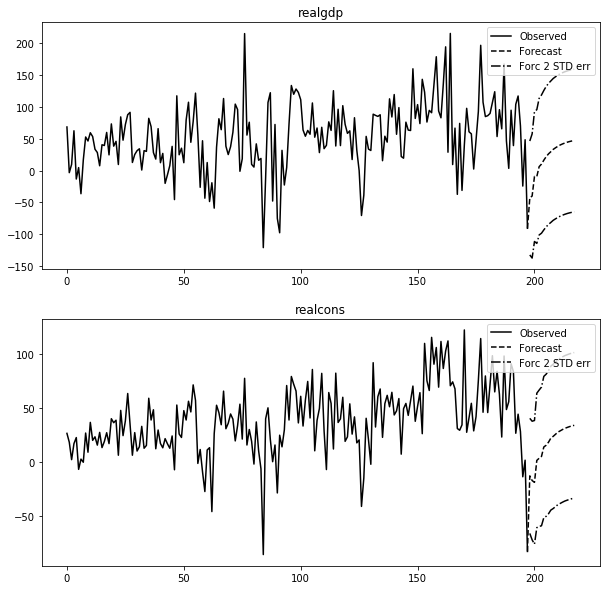

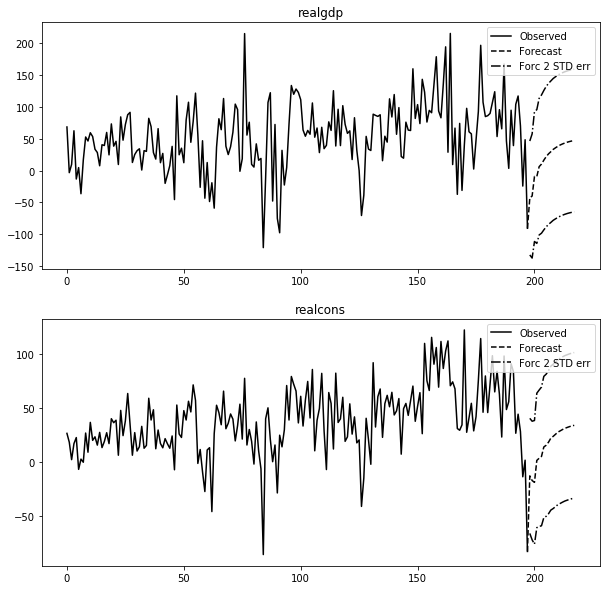

In [15]:
# plotting
results.plot_forecast(20)

### Evaluating   

to evaluate forecasting model using Forecast Error Variance Decomposition (FEVD) method using fevd() function.


In [17]:
# Evaluation
fevd = results.fevd(5)
fevd.summary()

FEVD for realgdp
      realgdp  realcons
0    1.000000  0.000000
1    0.855210  0.144790
2    0.806136  0.193864
3    0.762372  0.237628
4    0.732677  0.267323

FEVD for realcons
      realgdp  realcons
0    0.284790  0.715210
1    0.273130  0.726870
2    0.261571  0.738429
3    0.224091  0.775909
4    0.219314  0.780686




### Inverting
One final step remains. You didn’t fit the model to original data, because you had to transform (first difference) it to make data stationary in step 5b. So the forecast results need to be inverted to the original form.

In [20]:
results

In [19]:
# forecasting
pred = results.forecast(results.y, steps=nobs)
df_forecast = pd.DataFrame(pred, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast.tail()

/Users/tridoan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


,realgdp_1d,realcons_1d
199,-43.105826,-13.155471
200,-39.964603,-17.485063
201,-9.313311,-19.168514
202,-9.396031,1.192717


In [18]:
# inverting transformation
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_1d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc


# show inverted results in a dataframe
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['realgdp_forecast', 'realcons_forecast']]

/Users/tridoan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


,realgdp_forecast,realcons_forecast
199,13190.828174,9171.244529
200,13017.091744,9057.303996
201,12834.042004,8924.194948
202,12641.596233,8792.278617
